In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/tmp/ipykernel_2457887/2781717483.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


In [3]:
fig_out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures"

# Read in ICGC Data

In [4]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [5]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
# distance
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/comparison_sites*")
m_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/mean_metrics*")

In [6]:
# all metrics
"""icgc_dist_all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    # subset to only mutated sites
    one_metrics_df = one_metrics_df.loc[one_metrics_df["mutated_sample"] == True]
    icgc_dist_all_metrics_dfs.append(one_metrics_df)
icgc_dist_all_metrics_df = pd.concat(icgc_dist_all_metrics_dfs)
icgc_dist_all_metrics_df.reset_index(inplace=True, drop=True)"""

# write to one parquet file
#icgc_dist_all_metrics_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_all_metrics_no_matchedSample.parquet')
icgc_dist_all_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_all_metrics_no_matchedSample.parquet')

In [9]:
# mean metrics
icgc_dist_mean_metrics_df_l = []
for path in m_paths:
    # read in metrics sites from dask paruet
    one_metrics_df = pd.read_parquet(path)
    icgc_dist_mean_metrics_df_l.append(one_metrics_df)
icgc_dist_mean_metrics_df = pd.concat(icgc_dist_mean_metrics_df_l)

In [7]:
#icgc_dist_mean_metrics_w_annot_df = analyze_comethylation.add_mutation_info_to_mean_metrics_df(icgc_dist_mean_metrics_df, distance = 10000, consortium = 'ICGC')
#icgc_dist_mean_metrics_w_annot_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist.parquet')icgc_dist_mean_metrics_w_annot_df
icgc_dist_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist.parquet')

In [32]:
icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000")['mut_event'].nunique()

3880

In [16]:
icgc_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True")['mut_event'].nunique()

623083

In [15]:
icgc_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True")['mut_event'].nunique() / icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True")['mut_event'].nunique()

160.58840206185567

In [ ]:
# comparison sites
icgc_dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    icgc_dist_all_comparison_site_dfs.append(one_comp_df)
icgc_dist_all_comparison_site_df = pd.concat(icgc_dist_all_comparison_site_dfs)
icgc_dist_all_comparison_site_df.reset_index(inplace=True, drop=True)

# Read TCGA Data

In [17]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [18]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/comparison_sites*")

In [19]:
tcga_dist_all_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/dist_all_metrics_no_matchedSample.parquet')

In [20]:
tcga_dist_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/dist_mean_metrics_w_mut_info_df_10kb.parquet')

In [34]:
tcga_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000")['mut_event'].nunique()

7373

In [33]:
tcga_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True")['mut_event'].nunique()

627358

# A)KDE plot and B) ratio

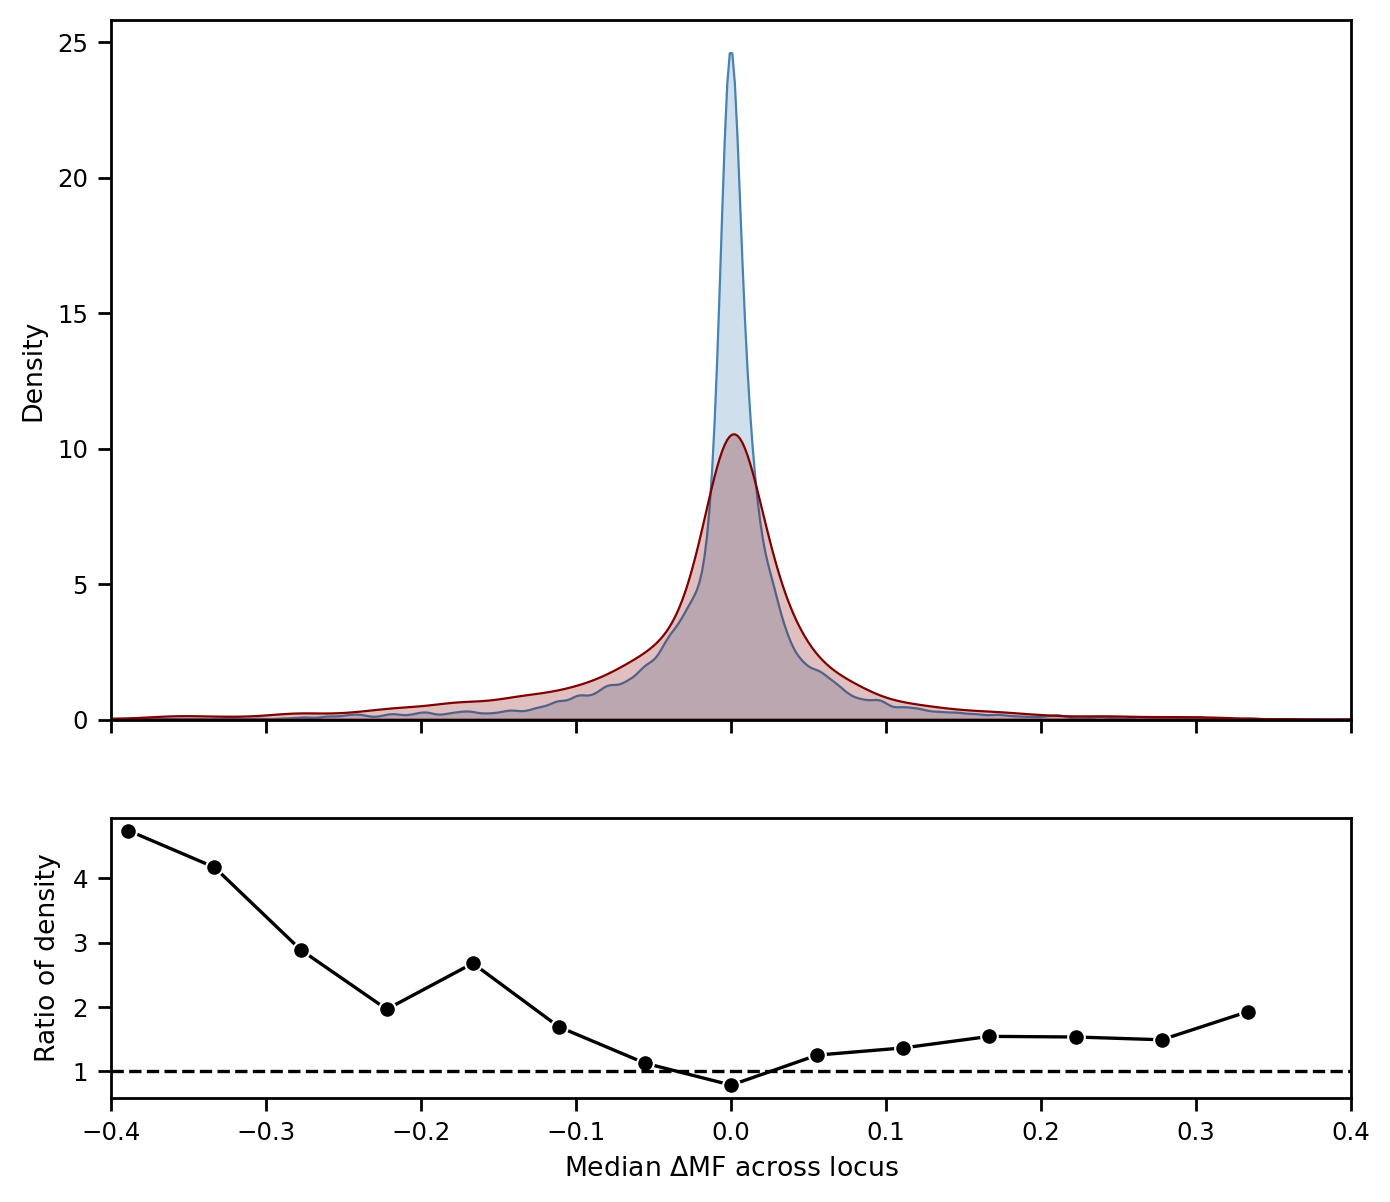

In [29]:
# make second axes bigger kw
fig, axes = plt.subplots(
    2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True
    )
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    icgc_dist_mean_metrics_w_annot_df,
    metric = 'median_dmf', axes = axes,
    consortium = 'ICGC', out_fn = os.path.join(fig_out_dir, 'figure3', 'figure3a_icgc_median_dmf_kde.svg')
    ) # set minimum ratio value to 15

# C) Distance of effect

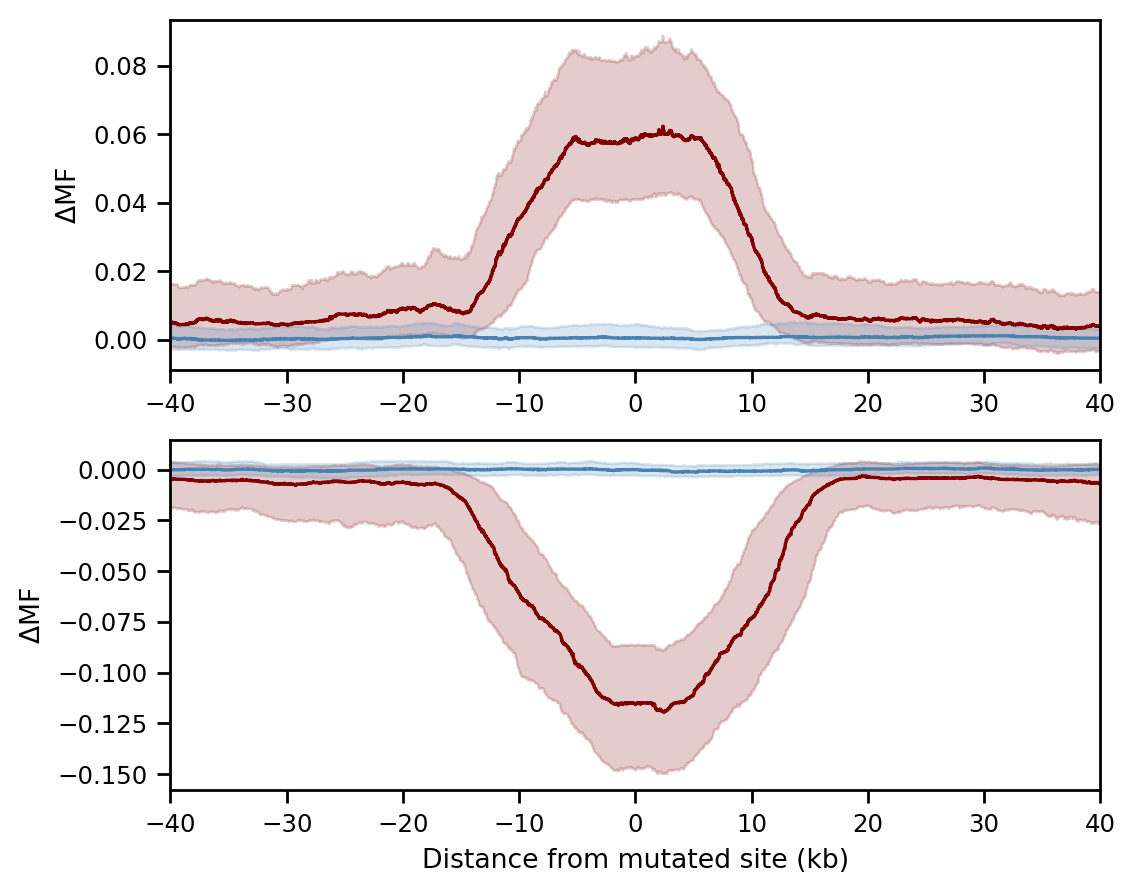

In [27]:
# 
fig, axes = analyze_comethylation.plot_distance_of_effect_lineplot( # smoothing_window_size_dist -2000
    icgc_dist_mean_metrics_df, icgc_dist_all_metrics_df, num_top_muts = 1000, # 25 %
    smoothing_window_size_dist = 2000, smoothing_window_size_corr = 300,
    corr_vs_dist = False, illumina_cpg_locs_df = illumina_cpg_locs_df,
    dist = 10000, plot_bg = True, out_fn = os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_rasterized.svg')
    )

In [25]:
fig.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_new_other.svg'), bbox_inches='tight',  dpi=900)

In [24]:
fig.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_new_other.png'), bbox_inches='tight',, format = 'png')

# D) boxplots of functional regions

Text(0.5, 0, 'Median $\\Delta$MF across locus')

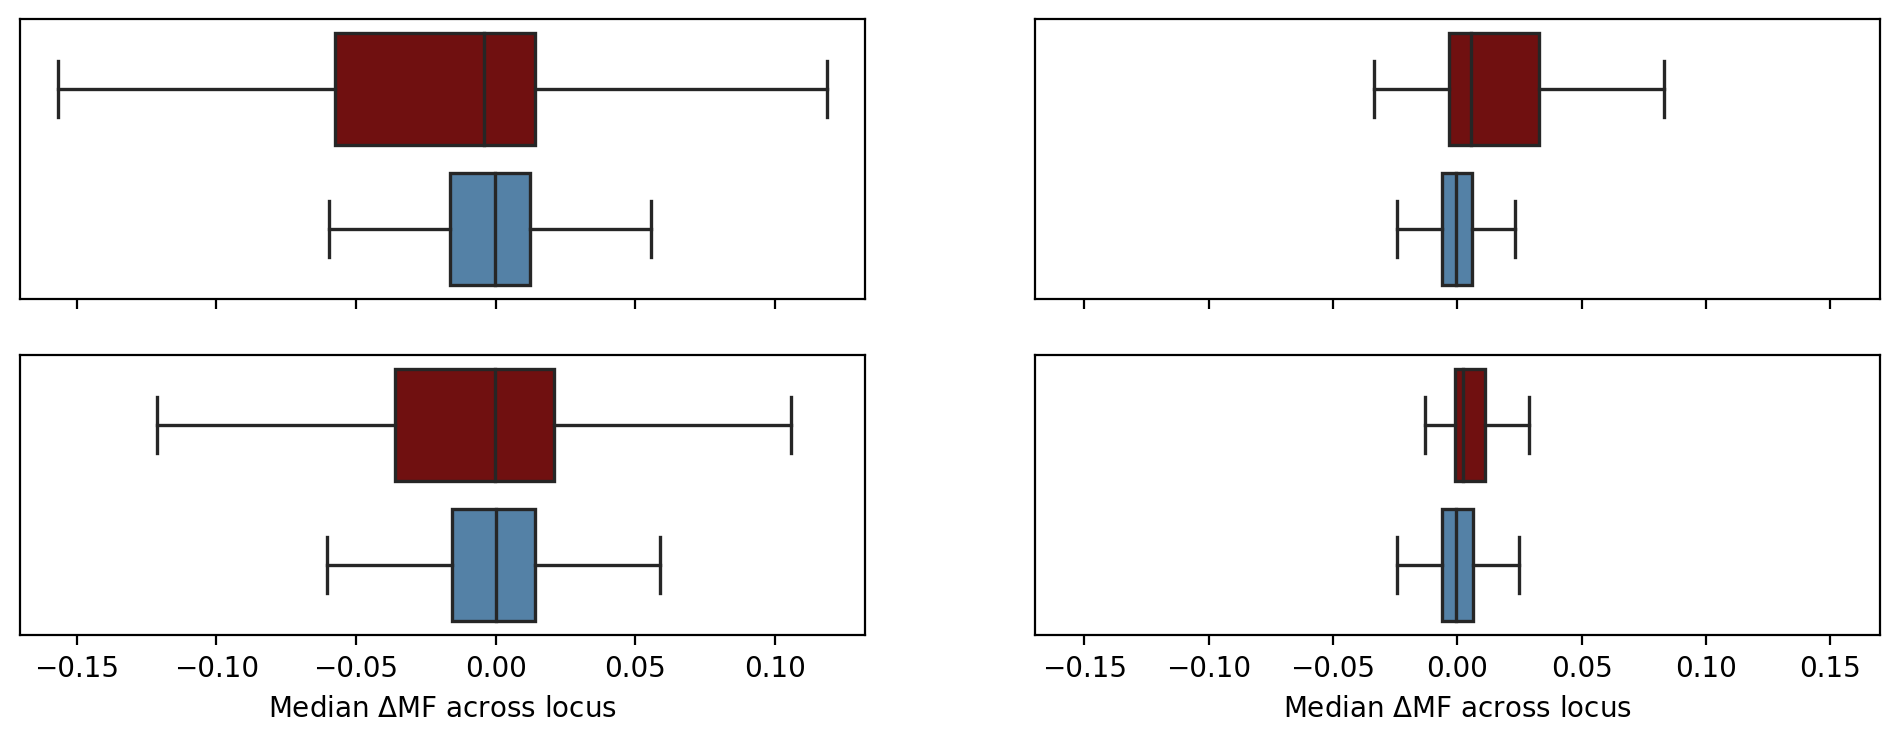

In [8]:
# make second axes bigger kw
fig, axes = plt.subplots(2,2, figsize = (12, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels
icgc_dist_mean_metrics_w_annot_df['is_cpg'] = icgc_dist_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
icgc_dist_mean_metrics_w_annot_df['is_cpg'] = icgc_dist_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

icgc_dist_mean_metrics_w_annot_df['is_cgi_renamed'] = icgc_dist_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

icgc_dist_mean_metrics_w_annot_df['combined_category'] = icgc_dist_mean_metrics_w_annot_df['is_cpg'] + '\n' + icgc_dist_mean_metrics_w_annot_df['is_cgi_renamed']

mut = icgc_dist_mean_metrics_w_annot_df.loc[icgc_dist_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
  

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[2], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[3], showfliers=False,order = ['Mutated', 'Random'] # bins=bins, stat='probability',
    #element= 'step', kde = True
    )
axes[3].set_xlim(-.17, .17)
for i in range(4):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[2].set_xlabel(r'Median $\Delta$MF across locus')
axes[3].set_xlabel(r'Median $\Delta$MF across locus')
plt.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3D_icgc_median_dmf_boxplot.svg'), dpi = 300, format = 'svg')

In [19]:
mut.query("is_cgi == True and is_cpg == 'Non-CpG'")['Locus'].value_counts()

Random     13119
Mutated      114
Name: Locus, dtype: int64

In [12]:
# choose top and bottom 10% of events
# select only a certain distance of median rows 
filtered_df = icgc_dist_mean_metrics_w_annot_df.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
# get top and bottom 1000 events, which is about 25%
num_top_muts = 1500
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
# create a new df to plot
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
top_bottom_df = pd.concat([top_df, bottom_df])

In [16]:
filtered_df.corr()

/tmp/ipykernel_2457887/3374119047.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  filtered_df.corr()


,mean_dmf,mean_abs_dmf,median_dmf,median_abs_dmf,distance,weighted_mean_dmf,log_weighted_mean_dmf,is_background,mutated_sample,start,DNA_VAF,end,was_cpg,becomes_cpg,is_cgi,gc_perc_200bp
mean_dmf,1.000000,-0.370786,0.979079,-0.383298,NaN,0.964824,0.998946,NaN,NaN,-0.013211,-0.075061,-0.013211,-0.036386,0.008788,0.045199,0.052527
mean_abs_dmf,-0.370786,1.000000,-0.376186,0.973826,NaN,-0.358394,-0.368621,NaN,NaN,-0.002401,0.121557,-0.002401,0.088625,-0.028516,-0.008542,-0.019223
median_dmf,0.979079,-0.376186,1.000000,-0.387588,NaN,0.940776,0.977562,NaN,NaN,-0.016676,-0.075792,-0.016676,-0.027869,0.005221,0.041383,0.050623
median_abs_dmf,-0.383298,0.973826,-0.387588,1.000000,NaN,-0.373468,-0.381891,NaN,NaN,0.004710,0.113920,0.004710,0.072578,-0.026307,-0.037956,-0.056884
distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weighted_mean_dmf,0.964824,-0.358394,0.940776,-0.373468,NaN,1.000000,0.975139,NaN,NaN,-0.018150,-0.075993,-0.018150,-0.035516,0.006322,0.076909,0.057039
log_weighted_mean_dmf,0.998946,-0.368621,0.977562,-0.381891,NaN,0.975139,1.000000,NaN,NaN,-0.015033,-0.074622,-0.015033,-0.035371,0.008540,0.049874,0.053192
is_background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mutated_sample,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start,-0.013211,-0.002401,-0.016676,0.004710,NaN,-0.018150,-0.015033,NaN,NaN,1.000000,0.004955,1.000000,-0.054451,0.013588,-0.027242,-0.074937


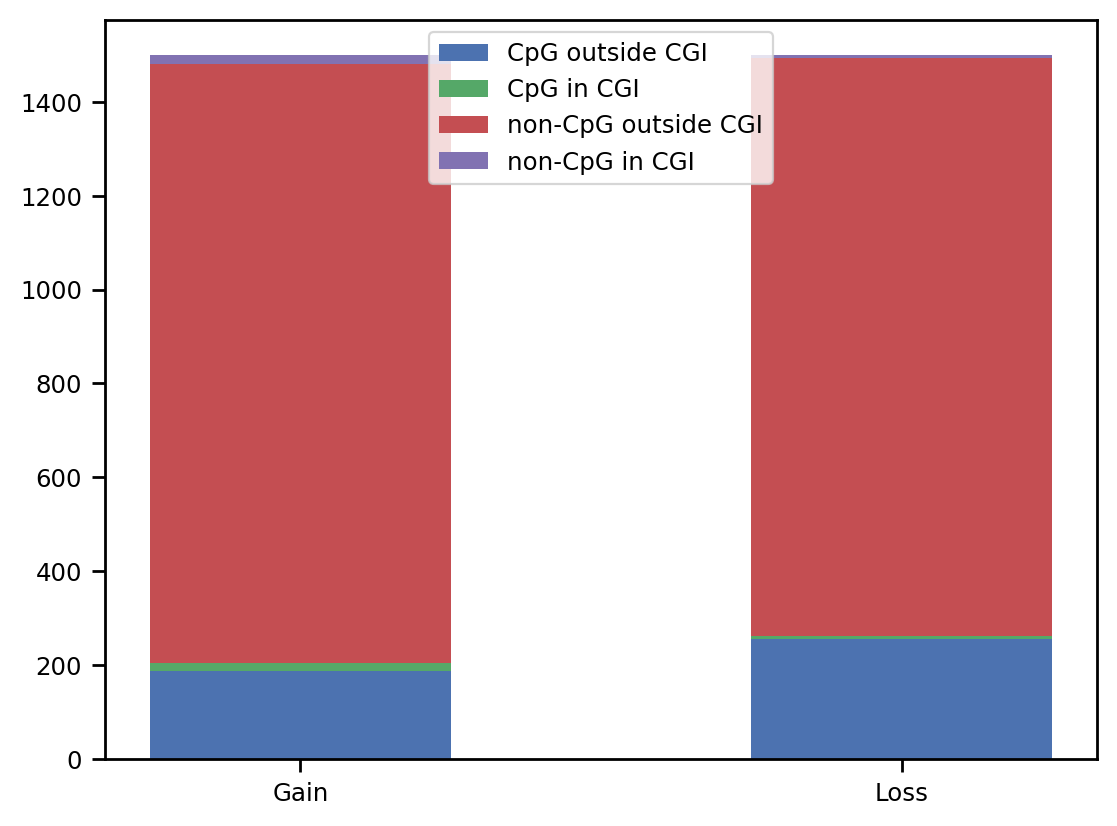

In [13]:
x_cats = ('Gain', "Loss")
y_counts = {
    "CpG outside CGI": np.array([
        top_df.query("is_cgi == False and is_cpg == 'CpG'").shape[0], 
        bottom_df.query("is_cgi == False and is_cpg == 'CpG'").shape[0]
        ]),
    "CpG in CGI": np.array([
        top_df.query("is_cgi == True and is_cpg == 'CpG'").shape[0],
        bottom_df.query("is_cgi == True and is_cpg == 'CpG'").shape[0]
        ]),
    "non-CpG outside CGI": np.array([
        top_df.query("is_cgi == False and is_cpg == 'Non-CpG'").shape[0],
        bottom_df.query("is_cgi == False and is_cpg == 'Non-CpG'").shape[0]
        ]),
    "non-CpG in CGI": np.array([
        top_df.query("is_cgi == True and is_cpg == 'Non-CpG'").shape[0],
        bottom_df.query("is_cgi == True and is_cpg == 'Non-CpG'").shape[0]
        ]),
}
width = 0.5
bottom = np.zeros(2)

for boolean, weight_count in y_counts.items():
    p = plt.bar(x_cats, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

plt.legend(loc="upper center")

plt.show()

In [14]:
y_counts

{'CpG outside CGI': array([188, 256]),
 'CpG in CGI': array([17,  6]),
 'non-CpG outside CGI': array([1275, 1231]),
 'non-CpG in CGI': array([20,  7])}

In [ ]:
# change so it is enrichment 

# what are we trying to show?
    # that depending where hte mutation occurs, and the local context, there are differential effects
    # 
    
# 1) add more annotations

# Supplemental TCGA Versions of all 

### KDE plot

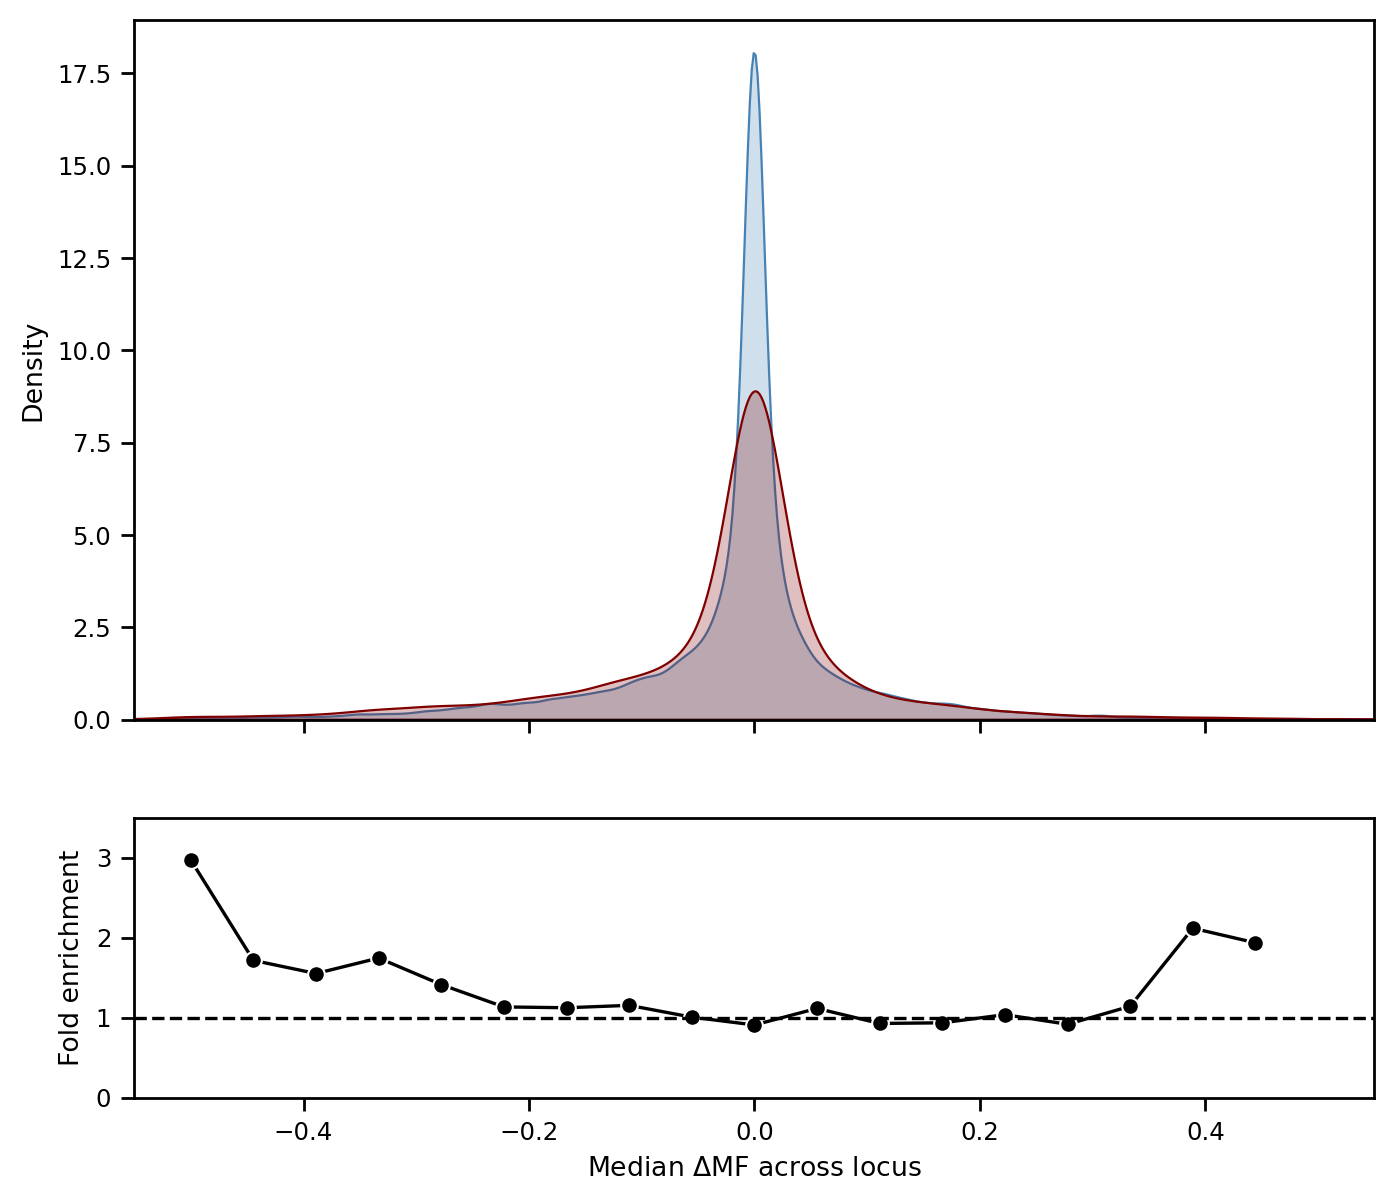

In [28]:
# make second axes bigger kw
fig, axes = plt.subplots(
    2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True
    )
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    tcga_dist_mean_metrics_w_annot_df,
    metric = 'median_dmf', axes = axes,
    consortium = 'TCGA', out_fn = os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_tcga_version_of_fig3b_kdeplot.svg')
    ) # set minimum ratio value to 15

### Distance of effect

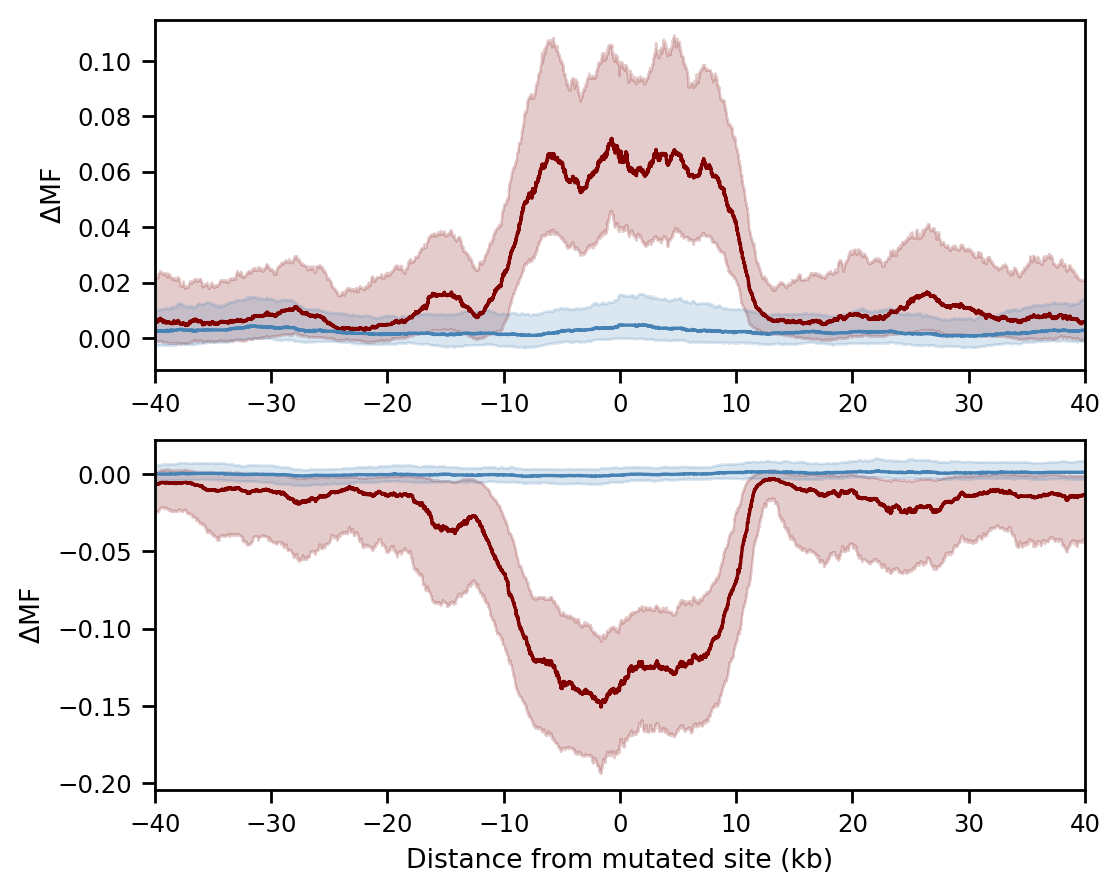

In [35]:
fig, axes = analyze_comethylation.plot_distance_of_effect_lineplot( # smoothing_window_size_dist -2000
    tcga_dist_mean_metrics_w_annot_df, tcga_dist_all_metrics_df, num_top_muts = 1875, # 25%
    smoothing_window_size_dist = 2000, smoothing_window_size_corr = 300,
    corr_vs_dist = False, illumina_cpg_locs_df = illumina_cpg_locs_df,
    dist = 10000, plot_bg = True, out_fn = os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_tcga_version_of_fig3C_distance_of_effect.svg')
    )

### Boxplots of functional regions

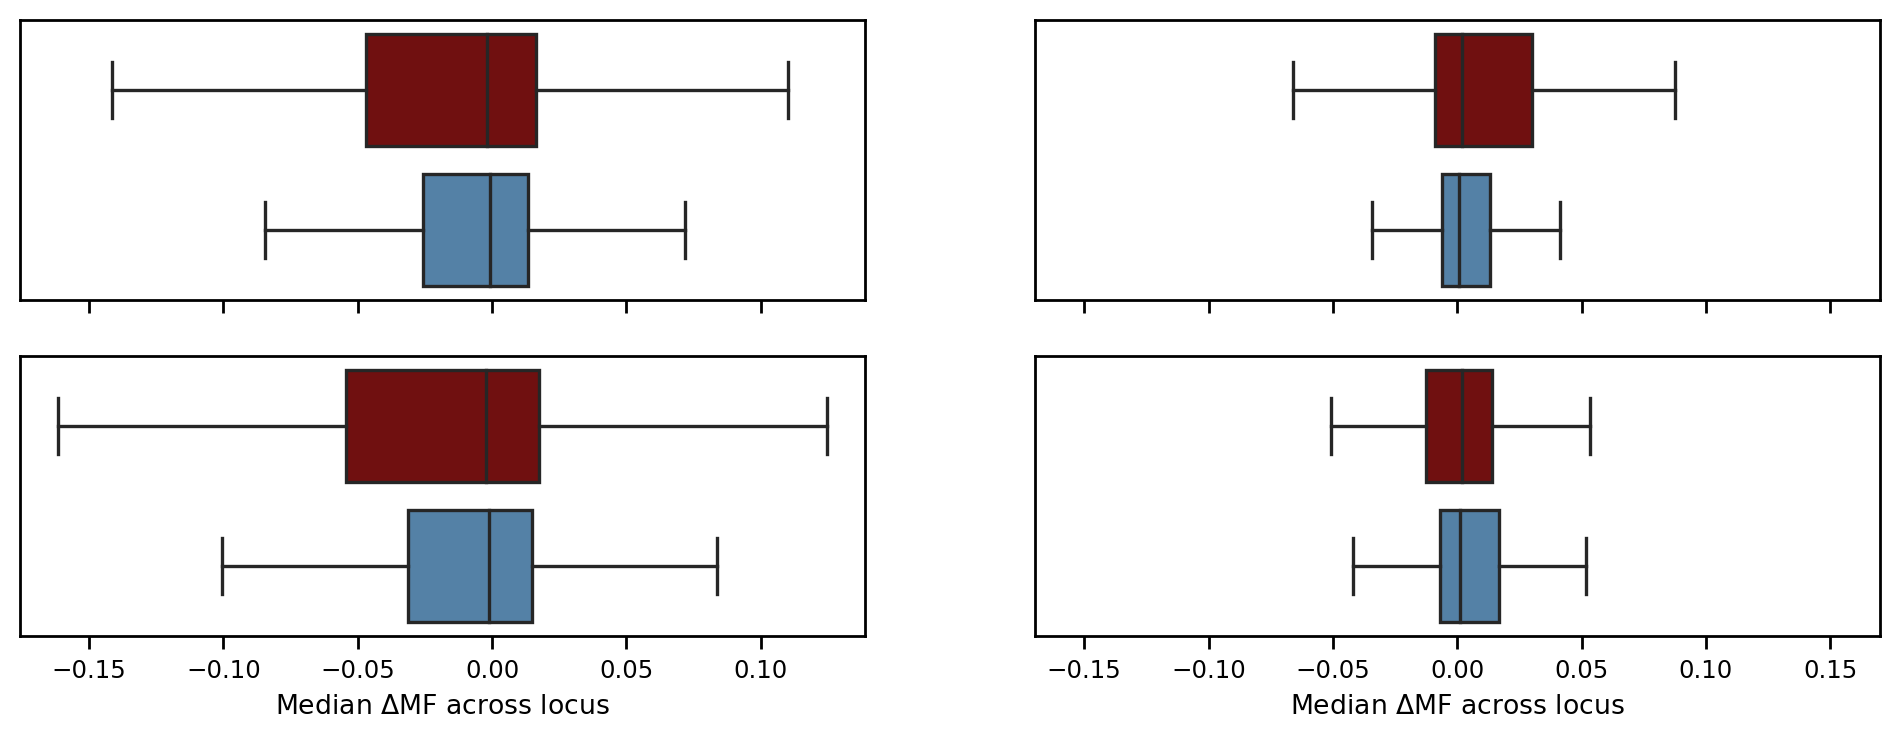

In [29]:
# make second axes bigger kw
fig, axes = plt.subplots(2,2, figsize = (12, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels
tcga_dist_mean_metrics_w_annot_df['is_cpg'] = tcga_dist_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
tcga_dist_mean_metrics_w_annot_df['is_cpg'] = tcga_dist_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

tcga_dist_mean_metrics_w_annot_df['is_cgi_renamed'] = tcga_dist_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

tcga_dist_mean_metrics_w_annot_df['combined_category'] = tcga_dist_mean_metrics_w_annot_df['is_cpg'] + '\n' + tcga_dist_mean_metrics_w_annot_df['is_cgi_renamed']

mut = tcga_dist_mean_metrics_w_annot_df.loc[tcga_dist_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
  

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[2], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[3], showfliers=False,order = ['Mutated', 'Random'] # bins=bins, stat='probability',
    #element= 'step', kde = True
    )
axes[3].set_xlim(-.17, .17)
for i in range(4):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[2].set_xlabel(r'Median $\Delta$MF across locus')
axes[3].set_xlabel(r'Median $\Delta$MF across locus')
plt.savefig(os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_tcga_version_of_fig3D_boxplots_by_fxnregion.svg'), dpi = 300, format = 'svg')

# Supplementary fig 3: DNA_VAF vs median dmf

SignificanceResult(statistic=0.06757797103048216, pvalue=4.775453144405756e-10)
PearsonRResult(statistic=0.08495957860331807, pvalue=4.764201540277238e-15)


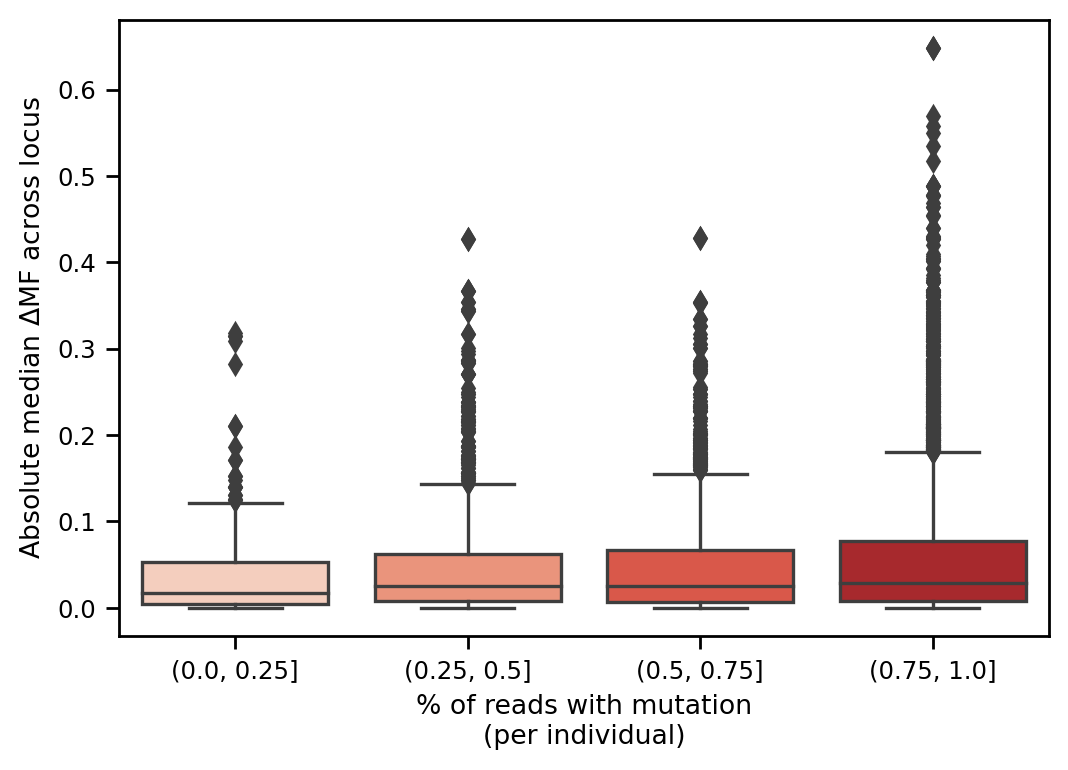

In [31]:
fig, axes = plt.subplots(figsize = (6,4), dpi = 100)
sns.set_context('paper')
# bin by DNA VAF
icgc_dist_mean_metrics_w_annot_df['DNA_VAF_bin'] = pd.cut(
    icgc_dist_mean_metrics_w_annot_df['DNA_VAF'],
    bins = pd.IntervalIndex.from_tuples([(0,.25), (.25, .5), (.5, .75), (.75, 1)])
        #[(0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1)])
    )
# get absolute value of median dmf
icgc_dist_mean_metrics_w_annot_df['abs_median_dmf'] = icgc_dist_mean_metrics_w_annot_df['median_dmf'].abs()
# boxplot
sns.boxplot(
    data=icgc_dist_mean_metrics_w_annot_df.query("is_background == False"),
    x='DNA_VAF_bin', y='abs_median_dmf', showfliers=True, palette = 'Reds',
    ax = axes
    )
# corrs, median_abs_dmf is better than abs_median_dmf
print(spearmanr(icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['DNA_VAF'], icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['median_abs_dmf']))
print(pearsonr(icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['DNA_VAF'], icgc_dist_mean_metrics_w_annot_df.query("is_background == False")['median_abs_dmf']))
axes.set_ylabel('Absolute median $\Delta$MF across locus')
axes.set_xlabel('% of reads with mutation\n(per individual)')
plt.savefig(os.path.join(fig_out_dir, 'supplemental', 'figure3_DNAVAF_vs_absDMF_distance_ICGC.svg'), dpi = 300, format = 'svg')

# Supp: GC content vs median dmf